In [1]:
import pandas as pd
import os

# Load the cleaned dataset from interim
file_path = "data/interim/german_credit.csv"
df = pd.read_csv(file_path)

print("Clean dataset loaded:", df.shape)
df.head()

Clean dataset loaded: (1000, 21)


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


In [4]:
# Assuming 'default' is the target variable
target = "credit_risk"
X = df.drop(columns=[target])
y = df[target]

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))

Features shape: (1000, 20)
Target distribution:
credit_risk
1    0.7
0    0.3
Name: proportion, dtype: float64


In [5]:
# Check class balance
print("Class distribution:")
print(y.value_counts())
print("\nClass distribution (%):")
print(y.value_counts(normalize=True) * 100)

Class distribution:
credit_risk
1    700
0    300
Name: count, dtype: int64

Class distribution (%):
credit_risk
1    70.0
0    30.0
Name: proportion, dtype: float64


In [6]:
from sklearn.model_selection import train_test_split

# Define target and features
target = "credit_risk"
X = df.drop(columns=[target])
y = df[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split done")
print("Train set size:", X_train.shape, "Target:", y_train.shape)
print("Test set size:", X_test.shape, "Target:", y_test.shape)

Split done
Train set size: (800, 20) Target: (800,)
Test set size: (200, 20) Target: (200,)


In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical vs numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Preprocessing transformers
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_cols),
        ("numerical", numerical_transformer, numerical_cols),
    ]
)

# Full pipeline (so far only preprocessing)
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform train/test sets
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)

Categorical columns: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Numerical columns: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']
Processed train shape: (800, 61)
Processed test shape: (200, 61)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Add model to pipeline
model = RandomForestClassifier(
    n_estimators=200,  # number of trees
    max_depth=None,   # let trees grow fully
    random_state=42,
    n_jobs=-1         # use all cores
)

clf = Pipeline(steps=[("preprocessor", preprocessor),
                     ("model", model)])

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.74

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.42      0.49        60
           1       0.78      0.88      0.83       140

    accuracy                           0.74       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.72      0.74      0.72       200


Confusion Matrix:
 [[ 25  35]
 [ 17 123]]


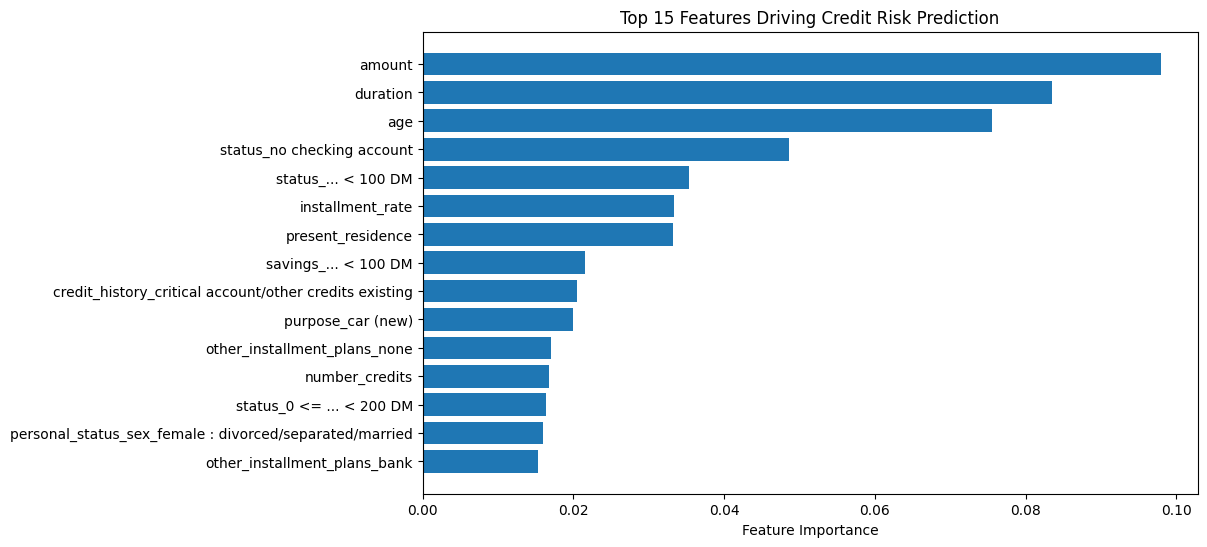

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names after preprocessing
feature_names = (
    preprocessor.named_transformers_["categorical"]
    .get_feature_names_out(categorical_cols)
)

all_feature_names = np.concatenate([feature_names, numerical_cols])

# Get importances
importances = clf.named_steps["model"].feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[indices[:15]][::-1], align="center")
plt.yticks(range(15), [all_feature_names[i] for i in indices[:15]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features Driving Credit Risk Prediction")
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train with class weights
rf_balanced = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight="balanced"  # <-- the key change
)

rf_balanced.fit(X_train_processed, y_train)
y_pred_balanced = rf_balanced.predict(X_test_processed)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))

Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.35      0.44        60
           1       0.76      0.89      0.82       140

    accuracy                           0.73       200
   macro avg       0.67      0.62      0.63       200
weighted avg       0.71      0.73      0.71       200


Confusion Matrix:
 [[ 21  39]
 [ 15 125]]


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",   # avoids warning
    scale_pos_weight=300/700 # balance classes (neg/pos ratio)
)

# Fit on training data
xgb_model.fit(X_train_processed, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_processed)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53        60
           1       0.80      0.80      0.80       140

    accuracy                           0.72       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.72      0.72      0.72       200


Confusion Matrix:
 [[ 32  28]
 [ 28 112]]


/Users/rohankatyayani/finrisk-copilot/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Base model
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [1, (len(y_train) - sum(y_train)) / sum(y_train)]  # balance classes
}

# Grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1_macro",  # or "recall" if you want to optimize recall
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train_processed, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get best model
best_xgb = grid_search.best_estimator_

# Evaluate
y_pred = best_xgb.predict(X_test_processed)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/rohankatyayani/finrisk-copilot/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rohankatyayani/finrisk-copilot/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rohankatyayani/finrisk-copilot/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rohankatyayani/finrisk-copilot/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:45:34] WARNING: /Users/runner/work/xgbo

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
Best Score: 0.6961849961977561
Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.50      0.53        60
           1       0.79      0.83      0.81       140

    accuracy                           0.73       200
   macro avg       0.68      0.66      0.67       200
weighted avg       0.72      0.73      0.73       200

Confusion Matrix:
 [[ 30  30]
 [ 24 116]]


In [16]:
best_model = grid_search.best_estimator_

                                              feature  importance
3             categorical__status_no checking account    0.089462
34               categorical__other_debtors_guarantor    0.031866
0                    categorical__status_... < 100 DM    0.030407
5   categorical__credit_history_critical account/o...    0.030361
11                    categorical__purpose_car (used)    0.026595
19                  categorical__savings_... < 100 DM    0.025320
10                     categorical__purpose_car (new)    0.023477
54                                numerical__duration    0.023015
40          categorical__other_installment_plans_bank    0.022987
41          categorical__other_installment_plans_none    0.022673
38                  categorical__property_real estate    0.021381
39          categorical__property_unknown/no property    0.021305
36  categorical__property_building society savings...    0.019513
28        categorical__employment_duration_unemployed    0.019041
35        

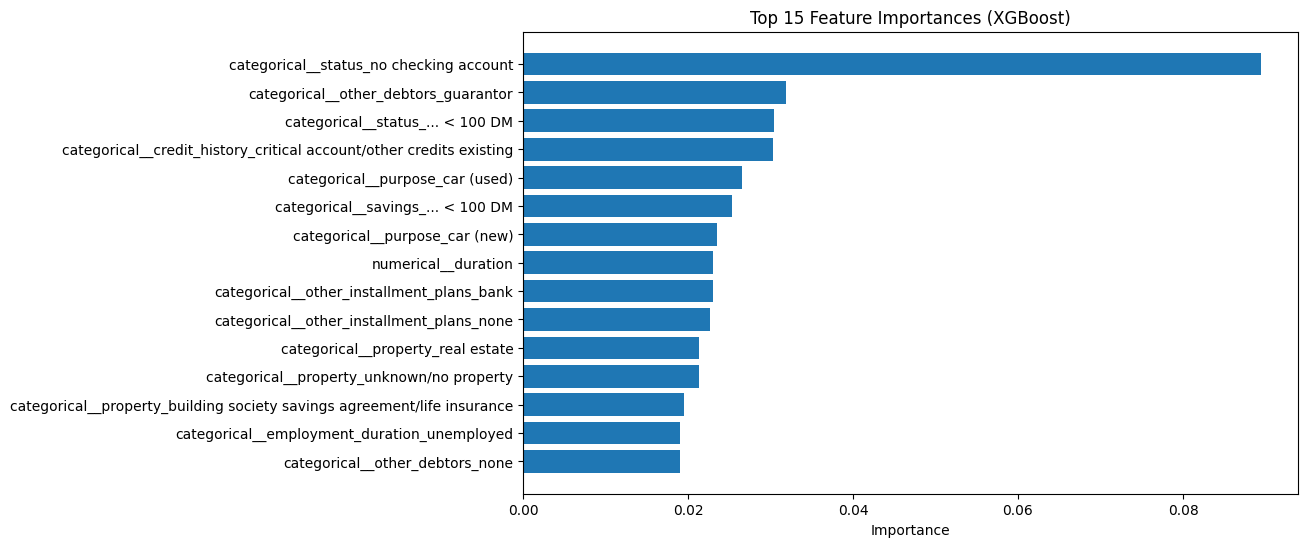

In [17]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Extract feature names from preprocessing pipeline
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Get feature importances from tuned XGBoost
importances = best_model.feature_importances_

# Put into DataFrame for easy sorting/plotting
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Show top 15 features
print(feat_imp.head(15))

# Plot feature importances
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"].head(15), feat_imp["importance"].head(15))
plt.gca().invert_yaxis()  # highest at top
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

                                              feature  importance
3             categorical__status_no checking account    0.089462
34               categorical__other_debtors_guarantor    0.031866
0                    categorical__status_... < 100 DM    0.030407
5   categorical__credit_history_critical account/o...    0.030361
11                    categorical__purpose_car (used)    0.026595
19                  categorical__savings_... < 100 DM    0.025320
10                     categorical__purpose_car (new)    0.023477
54                                numerical__duration    0.023015
40          categorical__other_installment_plans_bank    0.022987
41          categorical__other_installment_plans_none    0.022673
38                  categorical__property_real estate    0.021381
39          categorical__property_unknown/no property    0.021305
36  categorical__property_building society savings...    0.019513
28        categorical__employment_duration_unemployed    0.019041
35        

/var/folders/07/r0h04k150zn_5yl2kw993y6c0000gn/T/ipykernel_18641/3963974153.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(15), x="importance", y="feature", palette="viridis")


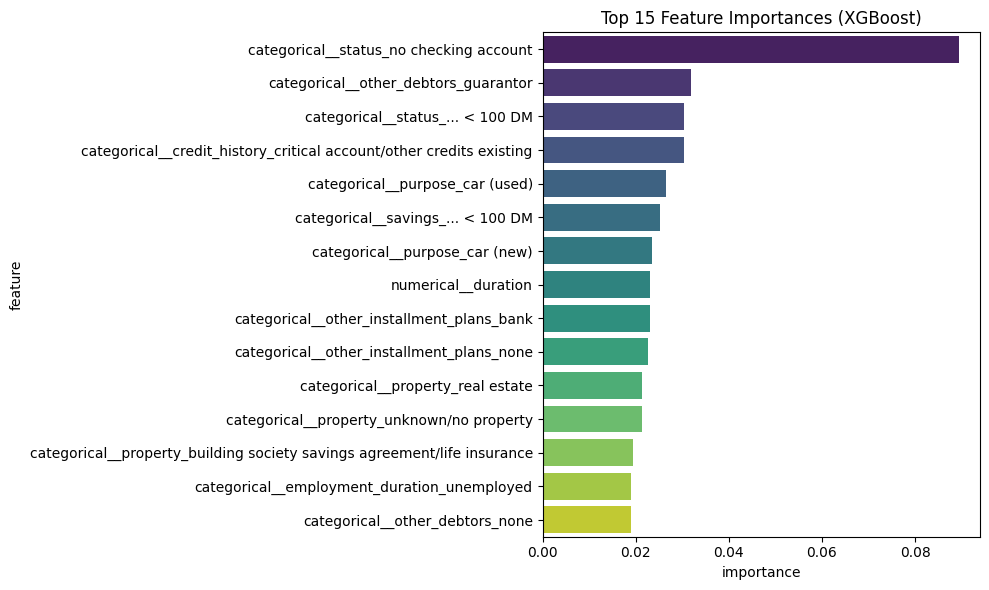

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature names after preprocessing
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Get feature importances from tuned XGBoost
importances = best_model.feature_importances_

# Put into DataFrame for sorting
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Show top 15 features
print(feat_imp.head(15))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature", palette="viridis")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

/var/folders/07/r0h04k150zn_5yl2kw993y6c0000gn/T/ipykernel_18641/2701770929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


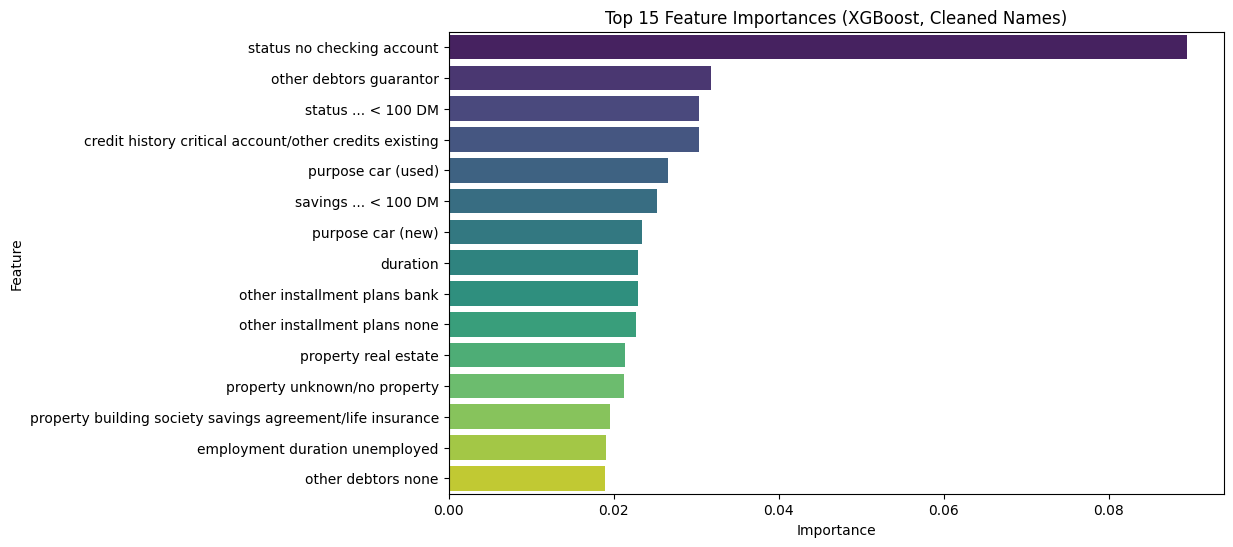

In [19]:
import re

# Map pipeline names back to original column names
def clean_feature_name(name):
    if name.startswith("categorical__"):
        return name.replace("categorical__", "").replace("_", " ")
    elif name.startswith("numerical__"):
        return name.replace("numerical__", "")
    else:
        return name

# Apply the mapping
feat_imp["clean_feature"] = feat_imp["feature"].apply(clean_feature_name)

# Plot again with clean labels
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp.head(15),
    x="importance",
    y="clean_feature",
    palette="viridis"
)
plt.title("Top 15 Feature Importances (XGBoost, Cleaned Names)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [20]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define LightGBM model
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

# Fit on training data
lgbm.fit(X_train_processed, y_train)

# Predictions
y_pred_lgbm = lgbm.predict(X_test_processed)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 560, number of negative: 240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define LightGBM model
lgbm = LGBMClassifier(random_state=42)

# Hyperparameter search space
param_dist = {
    "num_leaves": np.arange(20, 150, 10),
    "max_depth": [-1, 3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 300, 400],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1, 2, 3]  # helps with class imbalance
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=30,  # number of random combinations
    cv=3,
    scoring="f1",  # optimize for balanced performance
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train_processed, y_train)

# Best model
best_lgbm = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Evaluate on test set
y_pred_lgbm = best_lgbm.predict(X_test_processed)

print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 373, number of negative: 160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699812 -> initscore=0.846405
[LightGBM] [Info] Start training from score 0.846405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load clean dataset
df = pd.read_csv("data/interim/german_credit.csv")

# Define features and target
X = df.drop(columns=["credit_risk"])
y = df["credit_risk"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define categorical & numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessor
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_cols),
        ("numerical", numerical_transformer, numerical_cols),
    ]
)

# Recreate preprocessing pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Reuse your tuned LightGBM model
# If you still have it in the notebook, assign best_model = <your tuned model>
# Otherwise, we’ll retrain a quick LightGBM with tuned params:
from lightgbm import LGBMClassifier

best_model = LGBMClassifier(
    subsample=1.0,
    scale_pos_weight=2,
    num_leaves=30,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.8,
    random_state=42
)

# Fit model
best_model.fit(pipeline.fit_transform(X_train), y_train)

[LightGBM] [Info] Number of positive: 560, number of negative: 240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
               n_estimators=200, num_leaves=30, random_state=42,
               scale_pos_weight=2)

In [4]:
import os

# Create 'models' folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save pipeline
joblib.dump(final_pipeline, "models/credit_risk_model.pkl")
print("Model pipeline saved to models/credit_risk_model.pkl")

Model pipeline saved to models/credit_risk_model.pkl


In [5]:
import joblib
import numpy as np

# Load the pipeline back
loaded_model = joblib.load("models/credit_risk_model.pkl")

# Example: create a fake customer (just 1 row with same columns as X)
sample = X.iloc[[0]]  # take the first row of dataset as a test

# Predict
pred = loaded_model.predict(sample)
proba = loaded_model.predict_proba(sample)

print("Sample prediction (credit_risk):", pred[0])
print("Probability [Good, Bad]:", proba[0])

Sample prediction (credit_risk): 1
Probability [Good, Bad]: [0.07803785 0.92196215]
